In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [75]:
df = pd.read_csv('estadisticas_fantasy.csv')
print(df)

     Unnamed: 0          Nombre Posición        Equipo  Puntos  \
0             0     Lewandowski       DL  FC Barcelona     146   
1             1        Raphinha       DL  FC Barcelona     143   
2             2    Lamine Yamal       DL  FC Barcelona     137   
3             3    Vinícius Jr.       DL   Real Madrid     118   
4             4          Mbappe       DL   Real Madrid     102   
..          ...             ...      ...           ...     ...   
585         585         Vallejo       DF   Real Madrid      -1   
586         586          Adrián       PO    Real Betis      -2   
587         587  Rodrigo Abajas       DF   Valencia CF      -2   
588         588     Juan Carlos       PO        Girona      -3   
589         589        R Chasco       DF    Valladolid      -3   

     Media Puntos Relevo  Puntos Relevo Precio Actual Precio Inicial  Media  \
0                   2.85             37   127.371.980    127.397.088  11.23   
1                   3.23             42   125.574

In [67]:
print("num_atributs: ", len(df.keys()))
nan_columns = df.columns[df.isna().sum()>0].tolist()
print("NaNs: ", nan_columns)
print("num nans", df.isna().sum().sum())
print("Describe\n", df.describe())
print("\n\ninfo:\n", df.info())
print("\n\nnunique:\n", df.nunique())

num_atributs:  31
NaNs:  []
num nans 0
Describe
        Unnamed: 0      Puntos  Media Puntos Relevo  Puntos Relevo       Media  \
count  590.000000  590.000000           590.000000     590.000000  590.000000   
mean   294.500000   27.794915             0.893814       9.661017    2.543678   
std    170.462606   25.861069             0.795729       9.135669    2.227177   
min      0.000000   -3.000000             0.000000       0.000000   -0.330000   
25%    147.250000    7.250000             0.000000       0.000000    0.730000   
50%    294.500000   21.000000             0.750000       8.000000    2.180000   
75%    441.750000   46.000000             1.400000      15.000000    4.000000   
max    589.000000  146.000000             3.580000      43.000000   11.420000   

         Partidos      Minutos       Goles  Asistencias  Asistencias sin Gol  \
count  590.000000   590.000000  590.000000   590.000000           590.000000   
mean     9.001695   399.581356    0.479661     0.362712      

In [76]:
df.rename(columns={'Unnamed: 0': 'ID_jugador'}, inplace=True)

df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')

df = df[df['Posición'] != 'DT']
df.drop(columns=['Nombre'], inplace=True)

le = LabelEncoder()
df['Posición'] = le.fit_transform(df['Posición'])
df['Equipo'] = le.fit_transform(df['Equipo'])


0      DL
1      DL
2      DL
3      DL
4      DL
       ..
585    DF
586    PO
587    DF
588    PO
589    DF
Name: Posición, Length: 566, dtype: object
['DF' 'DL' 'MC' 'PO']
['Alavés' 'Athletic Club' 'Atlético de Madrid' 'Celta de Vigo' 'Espanyol'
 'FC Barcelona' 'Getafe' 'Girona' 'Las Palmas' 'Leganés' 'Mallorca'
 'Osasuna' 'Rayo Vallecano' 'Real Betis' 'Real Madrid' 'Real Sociedad'
 'Sevilla' 'Valencia CF' 'Valladolid' 'Villarreal CF']


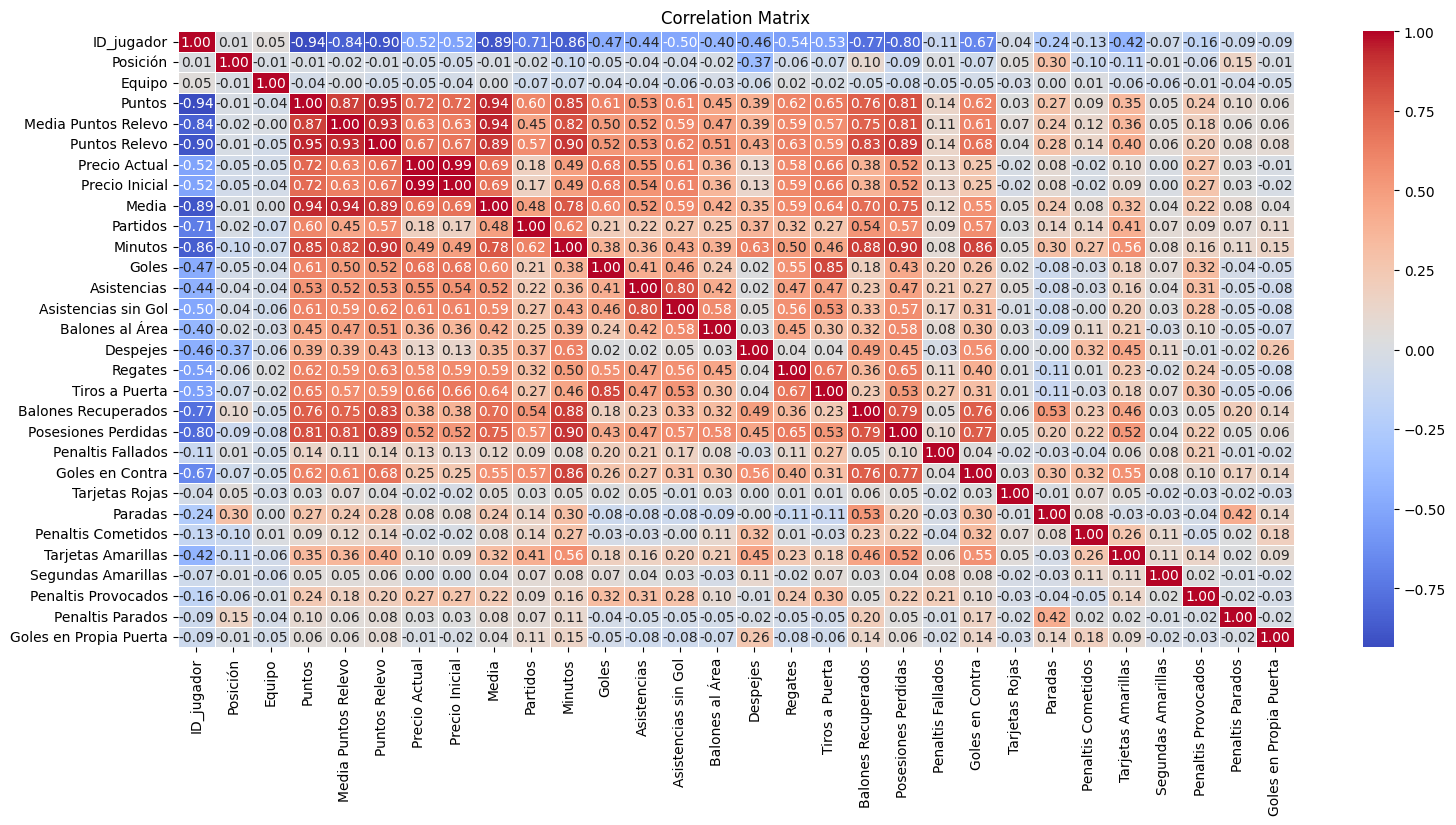

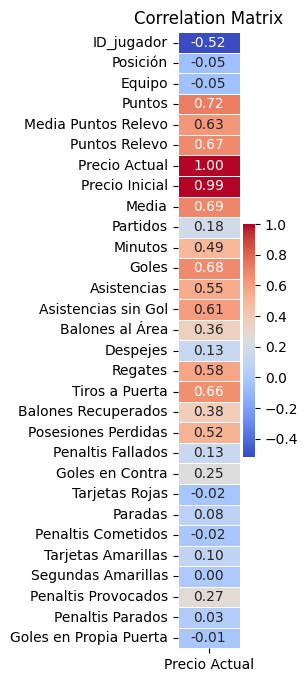

In [64]:
corr_matrix = df.corr()
corr_preu_actual = corr_matrix[['Precio Actual']]

plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

plt.figure(figsize=(1,8))
sns.heatmap(corr_preu_actual, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()